# Nice to Meat You : An Analysis on Meat Consumption

## Introduction

Meat consumption is a highly controversial topic in nowadays society in terms of [environment](https://www.theguardian.com/environment/2018/oct/10/huge-reduction-in-meat-eating-essential-to-avoid-climate-breakdown), [health](https://gamechangersmovie.com/), and [ethical](http://traslosmuros.com/en/slaughterhouse-documentary/) reasons. This situation introduces different ways of consuming meat and divides people according to their behaviors such as vegan, vegetarian, occasional meat consumer, and people consuming large amounts of meats.

In this project, we are particularly interested in the factors related to consuming meat and how the behavior of households varies according to their meat consumption. We are going to focus on demographic information such as economic status, family composition, age, and their relation with consuming meat. Moreover, we are going to study external effects that are related to meat consumption such as seasonal changes, campaigns, and discounts. Finally, we are going to categorize households according to their meat consumption and perform a behavior analysis per category.

To do so, we are going to use the Dunnhumby dataset. This dataset contains shopping information collected over two years from a group of 2,500 households as well as their information for each household. Moreover, we are planning to expand our analysis with an additional dataset about nutritional information.


## Factors that influence meat consumption

### Loading the data

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup

In [5]:
products = pd.read_csv('dunnhumby/product.csv', sep = ',')
meat_dept = ['MEAT-PCKGD','MEAT','MEAT-WHSE','PORK']
meat_products = products[products['DEPARTMENT'].isin(meat_dept)].copy()
meat_products.head(20)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
52,27951,69,MEAT-PCKGD,Private,DINNER SAUSAGE,FRESH,18 OZ
71,28267,69,MEAT-PCKGD,Private,DINNER SAUSAGE,FRESH,18 OZ
123,30003,397,MEAT-PCKGD,National,FROZEN MEAT,FRZN BREADED PREPARED CHICK,9 OZ
326,36722,397,MEAT-PCKGD,National,MEAT - MISC,BREAST - BONELESS(IQF),2.5 LB
338,37220,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16 OZ
340,37423,1107,MEAT-PCKGD,National,BREAKFAST SAUSAGE/SANDWICHES,LINKS - COOKED,7 OZ
363,38412,1094,MEAT-PCKGD,National,LUNCHMEAT,LUNCH COMBO,11.56 OZ
403,40394,1548,MEAT-PCKGD,National,BACON,BETTER FOR YOU,12 OZ
433,41071,2209,MEAT-PCKGD,National,DINNER SAUSAGE,FRESH,19.76 OZ
434,41128,2209,MEAT-PCKGD,National,DINNER SAUSAGE,FRESH,19.76 OZ


In [6]:
transactions = pd.read_csv('dunnhumby/transaction_data.csv', sep = ',')

### First look at the table

In [7]:
transactions.head(10)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


### Create the PAID PRICE column

In [8]:
transactions["PAID_PRICE"] = (transactions.SALES_VALUE - (transactions.RETAIL_DISC.abs() + transactions.COUPON_MATCH_DISC.abs())) / transactions.QUANTITY
transactions["PAID_PRICE"] = transactions["PAID_PRICE"].clip(lower=0)

In [9]:
transactions.head(5)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,PAID_PRICE
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,0.79
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,0.69
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1.21
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.11


### What is the most exapansive transaction ?

In [46]:
transactions[transactions.PAID_PRICE == transactions.PAID_PRICE.max()]

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,PAID_PRICE
547657,125,30031850855,201,1089093,1,455.0,323,0.0,1059,29,0.0,0.0,455.0


In [47]:
products[products.PRODUCT_ID == 1089093]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
36327,1089093,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


### When do people do their groceries ?

0    1744
dtype: int64

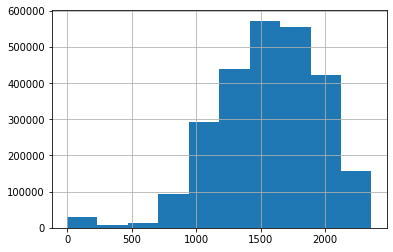

In [43]:
transactions.TRANS_TIME.hist()
transactions.TRANS_TIME.mode()

### How many unique stores ?

In [36]:
len(transactions.STORE_ID.unique())

582

### How many transactions?

In [10]:
print("Number of transactions: ")
len(transactions)

Number of transactions: 


2595732

### How many baskets ?

In [11]:
print("Number of baskets: ")
len(transactions.BASKET_ID.unique())

Number of baskets: 


276484

### How many products ?

In [12]:
print("Number of products: ")
len(transactions.PRODUCT_ID.unique())

Number of products: 


92339

### Are there an NAN values ?

In [13]:
transactions.isna().any()

household_key        False
BASKET_ID            False
DAY                  False
PRODUCT_ID           False
QUANTITY             False
SALES_VALUE          False
STORE_ID             False
RETAIL_DISC          False
TRANS_TIME           False
WEEK_NO              False
COUPON_DISC          False
COUPON_MATCH_DISC    False
PAID_PRICE            True
dtype: bool

In [14]:
transactions = transactions[transactions.QUANTITY > 0]

In [15]:
transactions.isna().any()

household_key        False
BASKET_ID            False
DAY                  False
PRODUCT_ID           False
QUANTITY             False
SALES_VALUE          False
STORE_ID             False
RETAIL_DISC          False
TRANS_TIME           False
WEEK_NO              False
COUPON_DISC          False
COUPON_MATCH_DISC    False
PAID_PRICE           False
dtype: bool

### What is the distribution of the basket price ?

Mean basket price: 19.13
Median basket price: 9.82


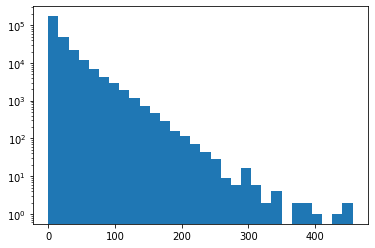

In [16]:
basket_prices = transactions.groupby("BASKET_ID").PAID_PRICE.sum()

print("Mean basket price: %.2f" % basket_prices.mean())
print("Median basket price: %.2f" % basket_prices.median())
plt.hist(basket_prices, bins=30)
plt.yscale("log")

In [17]:
basket_prices.sort_values(ascending=True)

BASKET_ID
31097462932      0.000000
27889003265      0.000000
28141111258      0.000000
29170533146      0.000000
40911601699      0.000000
                  ...    
33347880492    390.803333
27093315740    400.790000
29712930072    437.580000
32187143334    449.990000
30031850855    456.500000
Name: PAID_PRICE, Length: 275889, dtype: float64

We see that there are some baskets that cost 0 dollars. Let's have a look at one of these baskets :

In [22]:
transactions[transactions.BASKET_ID == 29170533146]

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,PAID_PRICE
403689,618,29170533146,165,1053460,1,0.0,316,0.0,1834,24,0.0,0.0,0.0


In [26]:
products[products.PRODUCT_ID == 1053460]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
32332,1053460,2745,COUP/STR & MFG,National,COUPONS/STORE & MFG,COUPONS/STORE & MFG,


### In Which department are there the most retail discounts ?

In [27]:
transactions_with_discount = transactions[transactions.RETAIL_DISC < 0.0]
transac_prod_with_disc = pd.merge(transactions_with_discount, products, on="PRODUCT_ID", how="inner")[["PRODUCT_ID", "RETAIL_DISC", "DEPARTMENT"]]

In [28]:
prodcts_by_dep = products.groupby("DEPARTMENT").count()["PRODUCT_ID"]
transac_by_dep = transac_prod_with_disc.groupby("DEPARTMENT").count()["RETAIL_DISC"]
normalized_discount_by_dep = transac_by_dep / prodcts_by_dep
normalized_discount_by_dep.sort_values(ascending=False)

DEPARTMENT
KIOSK-GAS          1266.625000
MISC SALES TRAN      32.704545
MEAT-PCKGD           28.993407
GROCERY              24.326952
SALAD BAR            22.958333
PRODUCE              19.802117
MEAT                 18.695755
SEAFOOD-PCKGD        12.925400
DELI                 11.215378
TRAVEL & LEISUR       9.071429
PASTRY                6.019544
CHEF SHOPPE           5.714286
DAIRY DELI            5.666667
PHARMACY SUPPLY       5.000000
COUP/STR & MFG        5.000000
NUTRITION             4.927591
SEAFOOD               4.604336
PHOTO                 3.000000
DRUG GM               2.634749
HBC                   2.000000
FROZEN GROCERY        1.521739
VIDEO RENTAL          1.333333
COSMETICS             0.990037
GARDEN CENTER         0.546875
CHARITABLE CONT       0.500000
GM MERCH EXP          0.333333
POSTAL CENTER         0.333333
TOYS                  0.333333
FLORAL                0.303838
MISC. TRANS.          0.289796
RESTAURANT            0.137255
                           N

### What is the average paid price by Department ?

In [31]:
transac_prod = pd.merge(transactions, products, on="PRODUCT_ID", how="inner")[["PRODUCT_ID", "PAID_PRICE", "DEPARTMENT"]]

In [32]:
average_price_by_dep = transac_prod.groupby("DEPARTMENT")["PAID_PRICE"].mean().sort_values(ascending=False)
average_price_by_dep

DEPARTMENT
VIDEO              11.590000
RX                 11.040714
SPIRITS             9.513825
PORK                7.850000
FLORAL              7.682257
AUTOMOTIVE          6.515556
GARDEN CENTER       5.903099
SEAFOOD             5.221887
MISC SALES TRAN     4.404429
RESTAURANT          4.023587
MISC. TRANS.        3.675989
MEAT                3.590639
DELI                3.588190
COSMETICS           3.279909
SEAFOOD-PCKGD       3.235831
DELI/SNACK BAR      3.229091
DRUG GM             3.086602
HOUSEWARES          2.990000
SALAD BAR           2.879742
PASTRY              2.540724
CHEF SHOPPE         2.537343
TRAVEL & LEISUR     2.532891
CNTRL/STORE SUP     2.502778
FROZEN GROCERY      2.338138
MEAT-PCKGD          2.291395
NUTRITION           2.177085
HBC                 2.020000
PROD-WHS SALES      1.880000
PHOTO               1.821765
GM MERCH EXP        1.738587
PRODUCE             1.721675
GROCERY             1.692921
PHARMACY SUPPLY     1.656667
CHARITABLE CONT     1.625000
TOY

### What is the average size of a basket ?

In [33]:
transactions.groupby("BASKET_ID").count()["PRODUCT_ID"].mean()

9.356175853332319

### How does the basket price evolve over weeks ?

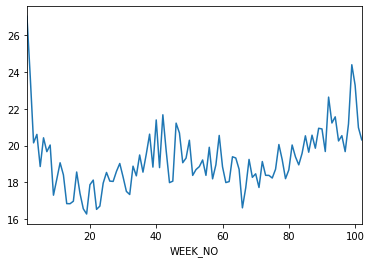

In [35]:
basket_values = transactions.groupby("BASKET_ID").agg({"PAID_PRICE": sum, "WEEK_NO": "first"}).reset_index()
avg_basket_value_per_week = basket_values.groupby("WEEK_NO")["PAID_PRICE"].mean()
avg_basket_value_per_week.plot()
# basket_value_per_week.sort_values(ascending=False)

In [139]:
coupon_disc_per_week = transactions.groupby("WEEK_NO").COUPON_DISC.sum()